In [0]:
!pip install extcolors
!pip install qpsolvers

  Created wheel for extcolors: filename=extcolors-0.1.3-cp36-none-any.whl size=6554 sha256=2581ce009385987b5aa107b757e2e712feb4ad16425ea17e7c18e8153f94367a
  Stored in directory: /root/.cache/pip/wheels/58/be/b4/7b0b1ca9b50115f79ae9ff23b1aab2f7acbcc8b484b629c597
Successfully built extcolors
  Created wheel for qpsolvers: filename=qpsolvers-1.0.7-cp36-none-any.whl size=14898 sha256=c33490cfb0fd3b1d4e4ca766796383725a08444d3e32ae2ef449f9b708fca512
  Stored in directory: /root/.cache/pip/wheels/cf/40/79/a40042e87a3f80b4c07d5e2177ab35883af23f55ded1498934
  Created wheel for quadprog: filename=quadprog-0.1.7-cp36-cp36m-linux_x86_64.whl size=307305 sha256=c2fb01f46dbb1184512f0efac64f68ec9075b719b143bb6b32ce37359b7dc7e5
  Stored in directory: /root/.cache/pip/wheels/36/dd/b1/849989444c0a5930927b260663019b7da6cff864fc224c2747
Successfully built qpsolvers quadprog


In [0]:
import os, glob
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import scipy.stats as stats
import cv2 as cv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cvx
from sklearn import model_selection as slms, preprocessing as spre
from skimage import measure as meas, feature as feat
from tqdm import tnrange, tqdm_notebook as tqdm
import numpy as np
import skimage as sm
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import io
import pandas as pd
import extcolors
import random
import sklearn.svm as svm
import cvxopt
import qpsolvers as qp

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Feature Extraction

In [0]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 0;
params.maxThreshold = 254;
 
# Filter by Area.
params.filterByArea = False

# Filter by Circularity
params.filterByCircularity = False

 
# Filter by Convexity
params.filterByConvexity = False

# Filter by Inertia
params.filterByInertia = False

In [0]:
new_entry = {'file name': [],'fruit type':[], 'rgbmean': [], 'convexity':[], 'circularity':[], 'inertia ratio':[]}
features = pd.DataFrame(new_entry)
path = "/content/drive/My Drive/186/fruits/"
fruit_folders = ["apples/", "oranges/", "bananas/"]
ind = 0
labels = ['red','orange','yellow']

for folder in fruit_folders:
    wdir = path + folder
    files = wdir+"*.jpg"
    ftype = labels[ind]
    ind +=1
    print(folder)
    for file in glob.glob(files):
        filename = file[-6:-4]
        fruit = cv2.imread(filename=file)
        
        gray = cv2.cvtColor(fruit, cv2.COLOR_BGR2GRAY)
        th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
        morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
        cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
        cnt = sorted(cnts, key=cv2.contourArea)[-1]
        x,y,w,h = cv2.boundingRect(cnt)
        dst = fruit[y:y+h, x:x+w]
        save_file = wdir+"cropped/"+filename+"-cropped.jpg"
        cv2.imwrite(save_file,dst)
        
        fruit_c = cv2.imread(filename=save_file)
        fruit_rgb_mean = np.mean(fruit_c/256)
        
        ret,thresh = cv2.threshold(gray,240,255,cv2.THRESH_BINARY_INV)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
      # Set up the detector with default parameters.
        detector = cv2.SimpleBlobDetector_create(params)
      # Detect blobs.
        keypoints = detector.detect(thresh)
        label, N = sm.measure.label(thresh, background=0, return_num=True)
        
        if N!=1:
            while N != 1:
                thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
                detector = cv2.SimpleBlobDetector_create(params)
                keypoints = detector.detect(thresh)
                label, N = sm.measure.label(thresh, background=0, return_num=True)
            #print(filename,N)
            binary = wdir+"cropped/"+filename+"-binary.jpg"
            cv2.imwrite(binary,thresh)
            reg = sm.measure.regionprops(label,thresh)
            area = reg[0].area
            conv_area = reg[0].convex_area
            perimeter = reg[0].perimeter
            inertia_a = reg[0].inertia_tensor_eigvals[0]
            inertia_b = reg[0].inertia_tensor_eigvals[1]
    
            convexity = area / conv_area
            circularity = (4* np.pi * area) / (perimeter**2)
            inertia = inertia_b/inertia_a
            #print(filename,' RGB MEAN:',fruit_rgb_mean,'; N:',N,'; Convexity:', convexity,'; Circularity:',circularity,'; Inertia:',inertia)
            new_entry = {'file name': filename,'fruit type':ftype,'rgbmean':fruit_rgb_mean, 'convexity':convexity, 'circularity':circularity, 'inertia ratio':inertia}
            features = features.append(new_entry, ignore_index=True)
        
            continue
        
        #print(N)
        binary = wdir+"cropped/"+filename+"-binary.jpg"
        cv2.imwrite(binary,thresh)
    
        reg = sm.measure.regionprops(label,thresh)
        area = reg[0].area
        conv_area = reg[0].convex_area
        perimeter = reg[0].perimeter
        inertia_a = reg[0].inertia_tensor_eigvals[0]
        inertia_b = reg[0].inertia_tensor_eigvals[1]
    
        convexity = area / conv_area
        circularity = (4* np.pi * area) / (perimeter**2)
        inertia = inertia_b/inertia_a        
        new_entry = {'file name': filename,'fruit type':ftype, 'rgbmean': fruit_rgb_mean,'convexity':convexity, 'circularity':circularity, 'inertia ratio':inertia}
        features = features.append(new_entry, ignore_index=True)

apples/


/usr/local/lib/python3.6/dist-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.6/dist-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


oranges/
bananas/


#Features

In [0]:
features

,file name,fruit type,rgbmean,convexity,circularity,inertia ratio
0,02,red,0.595774,0.999024,0.892545,0.885877
1,37,red,0.587019,0.970451,0.807966,0.899403
2,19,red,0.500390,0.967210,0.775939,0.746720
3,08,red,0.497882,0.991004,0.878732,0.827307
4,03,red,0.529208,0.965941,0.633915,0.726095
5,25,red,0.566883,0.976699,0.824910,0.808698
6,26,red,0.498262,0.977636,0.821655,0.964853
7,09,red,0.489888,0.962301,0.749591,0.826559
8,34,red,0.564600,0.975133,0.818959,0.860007
9,38,red,0.581233,0.936779,0.611577,0.889765


In [0]:
apple = features[features['fruit type'] == 'red']
banana = features[features['fruit type'] == 'yellow']
orange = features[features['fruit type'] == 'orange']

#Feature Spaces

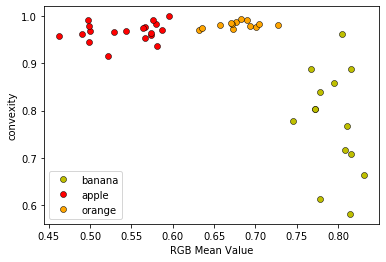

In [0]:
plt.plot(banana['rgbmean'], banana['convexity'], 'yo', mec='k', mew=0.5)
plt.plot(apple['rgbmean'], apple['convexity'], 'ro', mec='k', mew=0.5)
plt.plot(orange['rgbmean'], orange['convexity'], 'o', color='orange', mec='k', mew=0.5)
plt.legend(['banana', 'apple', 'orange'])
plt.xlabel('RGB Mean Value')
plt.ylabel('convexity')
# plt.savefig('ab-space.png', dpi=300, bbox_inches='tight')
plt.show()

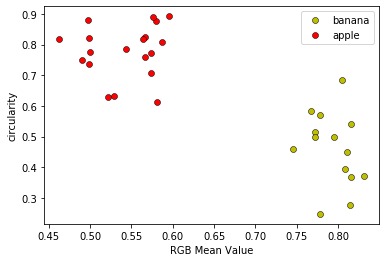

In [0]:
plt.plot(banana['rgbmean'], banana['circularity'], 'yo', mec='k', mew=0.5)
plt.plot(apple['rgbmean'], apple['circularity'], 'ro', mec='k', mew=0.5)
#plt.plot(orange['rgbmean'], orange['circularity'], 'o', color='orange', mec='k', mew=0.5)
plt.legend(['banana', 'apple', 'orange'])
plt.xlabel('RGB Mean Value')
plt.ylabel('circularity')
# plt.savefig('ab-space.png', dpi=300, bbox_inches='tight')
plt.show()

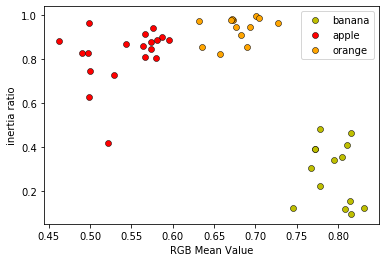

In [0]:
plt.plot(banana['rgbmean'], banana['inertia ratio'], 'yo', mec='k', mew=0.5)
plt.plot(apple['rgbmean'], apple['inertia ratio'], 'ro', mec='k', mew=0.5)
plt.plot(orange['rgbmean'], orange['inertia ratio'], 'o', color='orange', mec='k', mew=0.5)
plt.legend(['banana', 'apple', 'orange'])
plt.xlabel('RGB Mean Value')
plt.ylabel('inertia ratio')
# plt.savefig('ab-space.png', dpi=300, bbox_inches='tight')
plt.show()

#Reference Method

In [0]:
app_a = apple['rgbmean']
app_b = apple['convexity']
ban_a = banana['rgbmean']
ban_b = banana['convexity']
xdat = np.concatenate((app_a, ban_a))
ydat = np.concatenate((app_b, ban_b))
X = np.column_stack((xdat, ydat))
y = np.concatenate((np.ones(len(app_a)), -np.ones(len(ban_a))))

In [0]:
class SupportVectorMachine:
    def __init__(self, 
                 use_bias=False,                 
                 data_center=False,
                 data_std=False,
                 bias_initializer='ones',
                 tol=1e-12):
        self.use_bias = use_bias
        self.bias_initializer = bias_initializer
        self.data_center = data_center
        self.data_std = data_std
        self.tol = tol
    
    def get_initializer(self):
        if self.bias_initializer == 'ones':
            return np.ones
        elif self.bias_initializer == 'zeros':
            return np.zeros
        elif self.bias_initializer == 'random_uniform':
            return rand.random
        elif self.bias_initializer == 'random_normal':
            return rand.normal
    
    def train(self, X, y, solver='cvxpy', verbose=False):        
        if self.data_center:
            X -= X.mean()
        if self.data_std:
            X /= X.std()
        
        self.X = X
        self.y = y
        self.solver = solver
        
        if self.use_bias:
            self.bias = self.get_initializer()
            X = np.column_stack((self.bias(len(X)), X))
        H = (X.dot(X.T)) * (y.dot(y.T))
        A = -np.identity(len(X))
        a = np.zeros(len(X))
        B = np.vstack((y, np.zeros((len(y)-1, len(y)))))
        b = np.zeros(len(X))
        f = -np.ones(len(X))
        
        if solver == 'cvxpy':
            alpha = cvx.Variable(len(X))
            objective = cvx.Minimize(1/2*cvx.quad_form(alpha, H) + f.T@alpha)
            constraints = [A@alpha <= a, B@alpha == b]
            problem = cvx.Problem(objective, constraints)
            problem.solve(verbose=verbose)
            self.alpha = alpha.value
            self.alpha[self.alpha < self.tol] = 0
        elif solver == 'quadprog':
            self.alpha = qp.solve_qp(H, f, A, a, B, b, solver=solver)
        elif solver == 'libsvm':
            problem = svm.SVC(kernel='linear', verbose=verbose)
            problem.fit(X, y)
            self.clf = problem
            return
            
        w = (self.alpha*y).T.dot(X)
        self.supp_idx = np.squeeze(np.where(self.alpha > self.tol))
        w0 = 1/y[self.supp_idx[0]] - w.T.dot(X[self.supp_idx[0]])
        
        self.w = w
        self.w0 = w0
        self.m = -self.w[1]/self.w[2]
        self.b = -self.w[0]/self.w[2]
        
    def predict(self, X):
        if self.solver is not 'libsvm':
            return np.sign(self.w.T.dot(X) + self.b)
        else:
            return self.clf.predict(X)
    
    def plot_db(self, save=False):
        xmin, xmax = np.min(self.X.T[0])-1, np.max(self.X.T[0])+1
        ymin, ymax = np.min(self.X.T[1])-1, np.max(self.X.T[1])+1
        xx = np.linspace(xmin, xmax, 1000)
        yy = np.linspace(ymin, ymax, 1000)
        X, Y = np.meshgrid(xx, yy)
        Z = self.clf.predict(np.c_[X.ravel(), Y.ravel()])
        Z = Z.reshape(X.shape)
        w = self.clf.coef_[0]
        a = -w[0]/w[1]
        b = self.clf.intercept_[0]
        x = np.linspace(xmin, xmax)
        y = a*x - b/w[1]
        margin = 1/la.norm(self.clf.coef_, 2)
        nav = y - np.sqrt(1 + a**2)*margin
        pav = y + np.sqrt(1 + a**2)*margin
        fig, ax = plt.subplots(1, 1)
        
        if self.solver is not 'libsvm':
            ax.plot(*self.X[self.supp_idx].T, 'o', 
                     mfc='None', mew=1.5, mec='b', ms=10)
            ax.plot(x, self.m*x + self.b, 'k-', lw=1.5)
            legend = ax.legend(*scatter.legend_elements(), 
                               title='classes')
            ax.add_artist(legend)
        else:
            ax.contourf(X, Y, Z, cmap='YlOrRd_r', alpha=0.65)
            ax.plot(x, y, 'k-', lw=1.5)
            ax.plot(x, pav, 'k--', lw=1)
            ax.plot(x, nav, 'k--', lw=1)
            ax.plot(self.clf.support_vectors_.T[0], self.clf.support_vectors_.T[1],
                    'o', mfc='None', mew=1.5, ms=8, mec='b')
            
        scatter = ax.scatter(self.X.T[0], self.X.T[1], 
                             c=self.y, cmap='YlOrRd_r', edgecolors='k', 
                             linewidths=1)
        ax.set_xlabel('$a^*$')
        ax.set_ylabel('$b^*$')
        if save:
            plt.savefig('svm-db.png', dpi=300, bbox_inches='tight')
        plt.show()

[LibSVM]

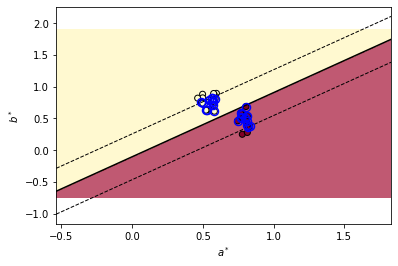

In [0]:
lin = SupportVectorMachine()
lin.train(X, y, solver='libsvm', verbose=True)
lin.plot_db(True)

TypeError: ignored

#My Method - Support Vector Machine

In [0]:
xdat = np.concatenate((apple['rgbmean'], banana['rgbmean']))
ydat = np.concatenate(( apple['circularity'], banana['circularity']))
X = np.column_stack((xdat, ydat))
z = np.concatenate((np.ones(len(apple['rgbmean'])), -np.ones(len(banana['rgbmean']))))
n_samples, n_features = X.shape

In [0]:
H = ((X.dot(X.T))*(z.dot(z.T)))
f = -np.ones(len(X))
A = -np.identity(len(X))
a = np.zeros(len(X))
B = np.vstack((z, np.zeros((len(z)-1, len(z)))))
b = np.zeros(len(X))

In [0]:
alpha = cvx.Variable(len(X))
objective = cvx.Minimize(0.5*cvx.quad_form(alpha, H) + f.T*alpha)
constraints = [A*alpha <= a, B*alpha == b]
problem = cvx.Problem(objective, constraints)
problem.solve(verbose=True)
alpha = alpha.value
print(alpha)
alpha[alpha < 1e-12] = 0
alpha

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 33, constraints m = 66
          nnz(P) + nnz(A) = 627
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -6.2239e-02   4.34e-02   6.00e-01   1.00e-01   3.99e-04s
 200  -2.4644e-02   1.15e-06   5.79e-05   6.26e-01   1.60e-03s
 250  -2.4645e-02   2.17e-07   3.44e-06   6.26e

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02464531, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02464531, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [0]:
w = (alpha*(z)).T.dot(X)
w = w*100

In [0]:
supp_idx = np.squeeze(np.where(alpha > 1e-12))
w0 = (1/z[0]) - w.T.dot(X[0])
print(w0)
b = -w0/w[1]
m = -w[0]/w[1]
print(m,b)

0.5404032559545089
0.6752562987882411 -0.5764404883676173


IndexError: ignored

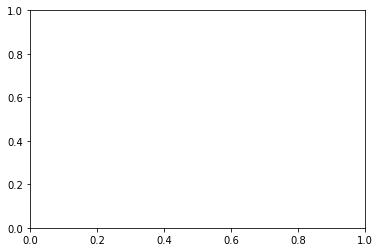

In [0]:
def f(x, w, b, c=0):
    return (-w[0] * x - b + c) / w[1]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')
ax = plt.gca()
xlim = ax.get_xlim()
xx = np.linspace(xlim[0], xlim[1])
yy = m * xx + b
plt.plot(xx, yy)

In [0]:
problem = svm.SVC(kernel='linear', verbose=False, max_iter = 10000000)
problem.fit(X, z)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=10000000, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

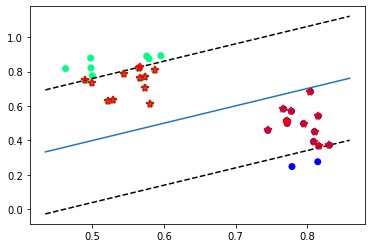

In [0]:
plt.scatter(X[:, 0], X[:, 1], c=z, cmap='winter');
ax = plt.gca()
xlim = ax.get_xlim()
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - clf.intercept_[0] / w[1]
plt.plot(xx, yy)
yy = a * xx - (clf.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
yy = a * xx - (clf.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')
ax.plot(clf.support_vectors_.T[0], clf.support_vectors_.T[1], '*', mfc='None', mew=1.5, ms=8, mec='r')

In [0]:
ax = plt.gca()
xlim = ax.get_xlim()
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - svc.intercept_[0] / w[1]
plt.plot(xx, yy)
yy = a * xx - (svc.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
yy = a * xx - (svc.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')

#My Method - Support Vector Machine via Packages

In [0]:
xdat = np.concatenate((apple['rgbmean'], banana['rgbmean']))
ydat = np.concatenate(( apple['circularity'], banana['circularity']))

In [0]:
X = np.column_stack((xdat, ydat))
y = np.concatenate((np.ones(len(apple['rgbmean'])), -np.ones(len(banana['rgbmean']))))

In [0]:
 n_samples, n_features = X.shape

In [0]:
K = np.zeros((n_samples, n_samples))
for i in range(n_samples):
  for j in range(n_samples):
    K[i,j] = np.dot(X[i], X[j])

(33, 33)

In [0]:
P = cvxopt.matrix(np.outer(y, y) * K)
q = cvxopt.matrix(np.ones(n_samples) * -1)
A = cvxopt.matrix(y, (1, n_samples))
b = cvxopt.matrix(0.0)
G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
h = cvxopt.matrix(np.zeros(n_samples))

In [0]:
solution = cvxopt.solvers.qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0: -1.1971e+01 -3.3195e+01  2e+01  1e-16  2e+00
 1: -1.6471e+01 -2.4041e+01  8e+00  7e-16  8e-01
 2: -2.6567e+01 -3.5891e+01  9e+00  4e-15  8e-01
 3: -4.7889e+01 -5.8784e+01  1e+01  2e-15  3e-01
 4: -5.2283e+01 -6.1089e+01  9e+00  1e-14  2e-01
 5: -5.5723e+01 -5.8639e+01  3e+00  9e-15  4e-02
 6: -5.4487e+01 -5.8600e+01  4e+00  2e-14  9e-15
 7: -5.5953e+01 -5.7218e+01  1e+00  2e-14  8e-15
 8: -5.6883e+01 -5.6974e+01  9e-02  1e-14  8e-15
 9: -5.6930e+01 -5.6935e+01  5e-03  2e-14  9e-15
10: -5.6931e+01 -5.6931e+01  7e-05  1e-14  8e-15
11: -5.6931e+01 -5.6931e+01  7e-07  2e-14  9e-15
Optimal solution found.


In [0]:
a = np.ravel(solution['x'])
a

array([1.65224872e-08, 1.77463344e-08, 2.45745532e-09, 2.24088820e-09,
       4.12112725e-09, 7.45907837e-09, 2.33308325e-09, 2.23312977e-09,
       7.09365448e-09, 5.69310750e+01, 4.62763225e-09, 9.40678629e-09,
       1.51940276e-08, 3.62781240e-09, 8.82025690e-09, 1.70412454e-09,
       1.12533480e-08, 8.12482234e-09, 2.48776667e-09, 1.79698955e-08,
       5.81861036e-09, 4.09993270e-09, 2.16130625e-08, 1.85215925e-08,
       1.86867638e+00, 2.88552497e-09, 3.52629596e-09, 4.30804609e-09,
       5.50623987e+01, 6.60952284e-09, 3.26444098e-09, 1.40011273e-08,
       4.30626068e-09])

In [0]:
sv = a > 1e-5
ind = np.arange(len(a))[sv]
ind

array([ 9, 24, 28])

In [0]:
a = a[ind]
a

array([56.93107502,  1.86867638, 55.06239866])

In [0]:
sv = X[ind]
sv

array([[0.58123307, 0.61157738],
       [0.74491927, 0.45916098],
       [0.76659002, 0.5834677 ]])

In [0]:
sv_y = y[ind]
sv_y

array([ 1., -1., -1.])

In [0]:
K[9]

array([0.89214394, 0.83532863, 0.76539012, 0.82679792, 0.69528095,
       0.83398731, 0.79211188, 0.74317221, 0.82902141, 0.71185878,
       0.79757736, 0.87216614, 0.76595937, 0.68759995, 0.79464745,
       0.76892528, 0.80523482, 0.87946015, 0.74026694, 0.80076136,
       0.60425796, 0.7106599 , 0.76337752, 0.75426092, 0.71378419,
       0.71070332, 0.69929698, 0.80529446, 0.80240312, 0.76643496,
       0.64228498, 0.88619578, 0.74688707])

In [0]:
b = 0
for n in range(len(a)):
  b += sv_y[n]
  b -= np.sum(a * sv_y )
b /= len(a)
b

-112.8621500677355

In [0]:
w = np.zeros(n_features)
for n in range(len(a)):
  w += a[n] *sv_y[n] *sv[n]
w

array([-10.51207475,   1.83260335])

In [0]:
def project(fspace):
  return np.dot(fspace, w) + b
def predict(fspace):
  return np.sign(project(fspace))

array([56.93107502,  1.86867638, 55.06239866])

In [0]:
tmp = np.ones(len(X))
tmp

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [0]:
y = tmp*y
y

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.])

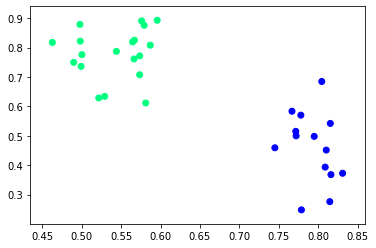

In [0]:
def f(x, w, b, c=0):
    return (-w[0] * x - b + c) / w[1]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

a0 = -4; a1 = f(a0, w, b)
b0 = 4; b1 = f(b0, w, b)
#plt.plot([a0,b0], [a1,b1], 'k')

a0 = -4; a1 = f(a0, w,b, 1)
b0 = 4; b1 = f(b0, w, b, 1)
#plt.plot([a0,b0], [a1,b1], 'k--')

a0 = -4; a1 = f(a0, w, b, -1)
b0 = 4; b1 = f(b0, w, b, -1)
#plt.plot([a0,b0], [a1,b1], 'k--')



In [0]:
import numpy as np
import cvxopt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

In [0]:
svc = LinearSVC(max_iter = 100000000)
svc.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=100000000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

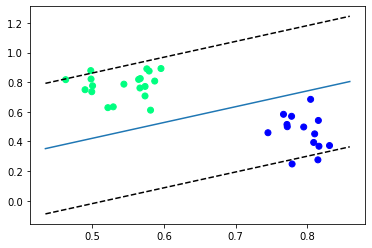

In [0]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter');
ax = plt.gca()
xlim = ax.get_xlim()
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - svc.intercept_[0] / w[1]
plt.plot(xx, yy)
yy = a * xx - (svc.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
yy = a * xx - (svc.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')

In [0]:
w

array([-2.42145074,  2.26851386])

In [0]:
f(-4,w,b,1)

205.53494005003202